ใน notebook นี้จะเป็นการสร้าง model cycleGAN ด้วย pytorch
 - cycleGAN เป็น model transfer จาก day to night และ night to day

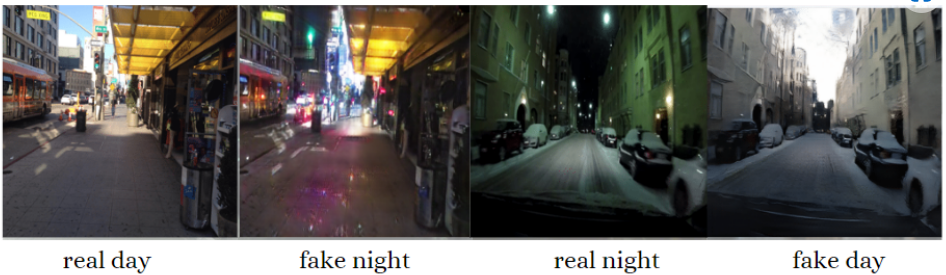

In [ ]:
!git clone 

## Import

In [1]:
import os 
os.chdir('/content/drive/MyDrive/cycle_GANV3')

In [2]:
from torchvision.transforms.transforms import ToTensor
import matplotlib.pyplot as plt
import torch
import torch.nn as nn  # All neural network modules, nn.Linear, nn.Conv2d, BatchNorm, Loss functions
import torch.optim as optim  # For all Optimization algorithms, SGD, Adam, etc.
import torchvision.transforms as transforms  # Transformations we can perform on our dataset
import torchvision
import os
import numpy as np
from skimage import io
from tqdm import tqdm
from torch.utils.data import (
    Dataset,
    DataLoader,
)  # Gives easier dataset managment and creates mini batches
import myconfig
from tqdm import tqdm

## load data

(256, 256, 3)
max(0.9960784316062927) min(0.0)
(256, 256, 3)
max(0.5405730605125427) min(0.040573082864284515)


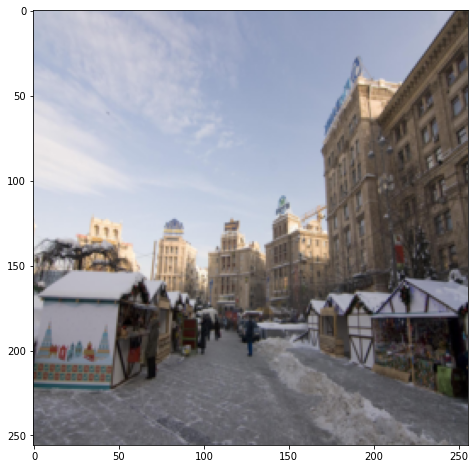

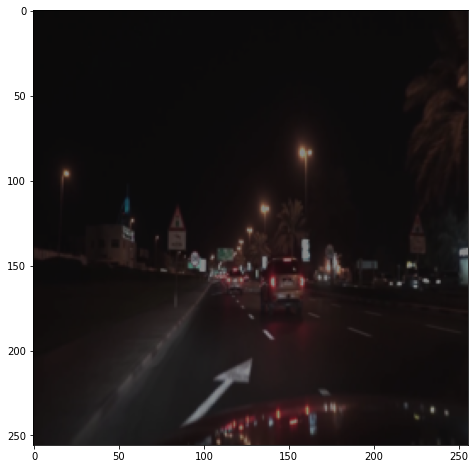

In [3]:
class CostomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.listfiles = os.listdir(root_dir)
        self.transform = transform
    def __len__(self):
        return len(self.listfiles)

    def __getitem__(self,index):
        img_path = os.path.join(self.root_dir, self.listfiles[index])
        image = io.imread(img_path)

        if self.transform:
            image = self.transform(image)
         
        return image

def plot_torch(img=None,dataloader=None,s=8):
    if dataloader:
        data = dataloader
        img_test = np.array(next(iter(data))[1])
    img_test = np.moveaxis(img_test,0,-1)
    plt.figure(figsize=(s,s))
    plt.imshow(img_test)
    print(img_test.shape)
    print(f'max({img_test.max()}) min({img_test.min()})')

if __name__ == '__main__':

    img_data_d = CostomDataset(root_dir='/content/drive/MyDrive/cycleGAN/pytorch-CycleGAN-and-pix2pix-master/datasets/data_v2/trainA', transform = myconfig.MYTRANSFORMS_day)
    img_data_n  = CostomDataset(root_dir = '/content/drive/MyDrive/cycleGAN/pytorch-CycleGAN-and-pix2pix-master/datasets/data_v2/trainB', transform = myconfig.MYTRANSFORMS_night)
    train_d = DataLoader(img_data_d ,batch_size=2,shuffle=True,pin_memory=True)
    train_n = DataLoader(img_data_n,batch_size=2,shuffle=True,pin_memory=True)
    plot_torch(dataloader = train_d)
    plot_torch(dataloader = train_n)

# cycle gan

## Discriminator

In [4]:

class Block(nn.Module):
    def __init__(self, in_channels, out_channels, stride):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 4, stride, 1, bias=True, padding_mode="reflect"),
            nn.InstanceNorm2d(out_channels),
            nn.LeakyReLU(0.2, inplace=True),
        )

    def forward(self, x):
        return self.conv(x)

class Discriminator(nn.Module):
    def __init__(self, in_channels=3 , features=[64,128,256,512]):
        super().__init__()
        self.initial = nn.Sequential(
            nn.Conv2d(
                in_channels,
                features[0],
                kernel_size=4,
                stride=2,
                padding=1,
                padding_mode="reflect",
            ),
            nn.LeakyReLU(0.2, inplace=True),
        )

        layers = []
        in_channels = features[0]
        for feature in features[1:]:
            layers.append(Block(in_channels,feature,stride=1 if feature == features[-1] else 2))
            in_channels = feature
        layers.append(nn.Conv2d(in_channels,1,kernel_size=4,stride=1,padding=1,padding_mode='reflect'))
        self.model = nn.Sequential(*layers)
        
    def forward(self,x):
        x = self.initial(x)
        return torch.sigmoid(self.model(x))


def test():
    x = torch.randn((5, 3, 256, 256))
    model = Discriminator(in_channels=3)
    preds = model(x)
    print(preds.shape)
test()

torch.Size([5, 1, 30, 30])


## Generator

In [5]:
import torch
import torch.nn as nn

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, down=True, use_act=True, **kwargs):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, padding_mode="reflect", **kwargs)
            if down
            else nn.ConvTranspose2d(in_channels, out_channels, **kwargs),
            nn.InstanceNorm2d(out_channels),
            nn.ReLU(inplace=True) if use_act else nn.Identity()
        )

    def forward(self, x):
        return self.conv(x)

class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.block = nn.Sequential(
            ConvBlock(channels, channels, kernel_size=3, padding=1),
            ConvBlock(channels, channels, use_act=False, kernel_size=3, padding=1),
        )

    def forward(self, x):
        return x + self.block(x)

class Generator(nn.Module):
    def __init__(self, img_channels, num_features = 64, num_residuals=9):
        super().__init__()
        self.initial = nn.Sequential(
            nn.Conv2d(img_channels, num_features, kernel_size=7, stride=1, padding=3, padding_mode="reflect"),
            nn.InstanceNorm2d(num_features),
            nn.ReLU(inplace=True),
        )
        self.down_blocks = nn.ModuleList(
            [
                ConvBlock(num_features, num_features*2, kernel_size=3, stride=2, padding=1),
                ConvBlock(num_features*2, num_features*4, kernel_size=3, stride=2, padding=1),
             
            ]
        )
        self.res_blocks = nn.Sequential(
            *[ResidualBlock(num_features*4) for _ in range(num_residuals)]
        )
        self.up_blocks = nn.ModuleList(
            [
                ConvBlock(num_features*4, num_features*2, down=False, kernel_size=3, stride=2, padding=1, output_padding=1),
                ConvBlock(num_features*2, num_features*1, down=False, kernel_size=3, stride=2, padding=1, output_padding=1),
            ]
        )

        self.last = nn.Conv2d(num_features*1, img_channels, kernel_size=7, stride=1, padding=3, padding_mode="reflect")

    def forward(self, x):
        x = self.initial(x)
        for layer in self.down_blocks:
            x = layer(x)
        x = self.res_blocks(x)
        for layer in self.up_blocks:
            x = layer(x)
        return torch.tanh(self.last(x))

def test():
    img_channels = 3
    img_size = 256
    x = torch.randn((2, img_channels, img_size, img_size))
    gen = Generator(img_channels, 9)
    print(gen(x).shape)

if __name__ == "__main__":
    test()

torch.Size([2, 3, 256, 256])


## training loop

In [9]:
import torch
import sys
from utils import save_checkpoint, load_checkpoint
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import myconfig
from tqdm import tqdm
from torchvision.utils import save_image


def train_fn(disc_n, disc_d, gen_d, gen_n, loader, opt_disc, opt_gen, l1, mse, d_scaler, g_scaler):
    n_reals = 0
    n_fakes = 0
    loop = loader
    for idx, (day, night) in enumerate(loop):
        day = day.to(myconfig.DEVICE)
        night = night.to(myconfig.DEVICE)

        # Train Discriminators night and day
        with torch.cuda.amp.autocast():
            fake_night = gen_n(day)
            D_n_real = disc_n(night)
            D_n_fake = disc_n(fake_night.detach())
            n_reals += D_n_real.mean().item()
            n_fakes += D_n_fake.mean().item()
            D_n_real_loss = mse(D_n_real, torch.ones_like(D_n_real))
            D_n_fake_loss = mse(D_n_fake, torch.zeros_like(D_n_fake))
            D_n_loss = D_n_real_loss + D_n_fake_loss

            fake_day = gen_d(night)
            D_d_real = disc_d(day)
            D_d_fake = disc_d(fake_day.detach())
            D_d_real_loss = mse(D_d_real, torch.ones_like(D_d_real))
            D_d_fake_loss = mse(D_d_fake, torch.zeros_like(D_d_fake))
            D_d_loss = D_d_real_loss + D_d_fake_loss

            # put it togethor
            D_loss = (D_n_loss + D_d_loss)/2
        opt_disc.zero_grad()
        d_scaler.scale(D_loss).backward()
        d_scaler.step(opt_disc)
        d_scaler.update()

        # Train Generators night and day
        with torch.cuda.amp.autocast():
            # adversarial loss for both generators
            D_n_fake = disc_n(fake_night)
            D_d_fake = disc_d(fake_night)
            loss_G_n = mse(D_n_fake, torch.ones_like(D_n_fake))
            loss_G_d = mse(D_d_fake, torch.ones_like(D_d_fake))

            # cycle loss
            cycle_day = gen_d(fake_night)
            cycle_night = gen_n(fake_day)
            cycle_day_loss = l1(day, cycle_day)
            cycle_night_loss = l1(night, cycle_night)

            # identity loss (remove these for efficiency if you set lambda_identity=0)
            identity_day = gen_d(day)
            identity_night = gen_n(night)
            identity_day_loss = l1(day, identity_day)
            identity_night_loss = l1(night, identity_night)

            # add all togethor
            G_loss = (
                loss_G_d
                + loss_G_n
                + cycle_day_loss * myconfig.LAMBDA_CYCLE
                + cycle_night_loss * myconfig.LAMBDA_CYCLE
                + identity_night_loss * myconfig.LAMBDA_IDENTITY
                + identity_day_loss * myconfig.LAMBDA_IDENTITY
            )
        print(f"loss_G_n={loss_G_n.item()} D_n_loss={D_n_loss.item()} loss_G_d={loss_G_d} D_d_loss = {D_d_loss.item()} ")
        opt_gen.zero_grad()
        g_scaler.scale(G_loss).backward()
        g_scaler.step(opt_gen)
        g_scaler.update()
        if idx % 100 == 0:
            print(f'iter{idx}')
            save_image(fake_night*0.5+0.5, f"saved_images/night_{idx}.png")
            save_image(fake_day*0.5+0.5, f"saved_images/day_{idx}.png")

        #loop.set_postfix(n_real=n_reals/(idx+1), n_fake=n_fakes/(idx+1))


def main():
    disc_n = Discriminator(in_channels=3).to(myconfig.DEVICE)
    disc_d = Discriminator(in_channels=3).to(myconfig.DEVICE)
    gen_d = Generator(img_channels=3, num_residuals=9).to(myconfig.DEVICE)
    gen_n = Generator(img_channels=3, num_residuals=9).to(myconfig.DEVICE)
    opt_disc = optim.Adam(
        list(disc_n.parameters()) + list(disc_d.parameters()),
        lr= myconfig.LEARNING_RATE,
        betas=(0.5, 0.999),
    )

    opt_gen = optim.Adam(
        list(gen_d.parameters()) + list(gen_n.parameters()),
        lr= myconfig.LEARNING_RATE,
        betas=(0.5, 0.999),
    )

    L1 = nn.L1Loss()
    mse = nn.MSELoss()

    if myconfig.LOAD_MODEL:
        load_checkpoint(
            myconfig.CHECKPOINT_GEN_night, gen_n, opt_gen, myconfig.LEARNING_RATE,
        )
        load_checkpoint(
            myconfig.CHECKPOINT_GEN_day, gen_d, opt_gen, myconfig.LEARNING_RATE,
        )
        load_checkpoint(
            myconfig.CHECKPOINT_CRITIC_night, disc_n, opt_disc, myconfig.LEARNING_RATE,
        )
        load_checkpoint(
            myconfig.CHECKPOINT_CRITIC_day, disc_d, opt_disc, myconfig.LEARNING_RATE,
        )

    dataset = zip(train_d, train_n)

    g_scaler = torch.cuda.amp.GradScaler()
    d_scaler = torch.cuda.amp.GradScaler()

    for epoch in range(myconfig.NUM_EPOCHS):
        print(f'epoch {epoch} / {myconfig.NUM_EPOCHS}')
        train_fn(disc_n, disc_d, gen_d, gen_n, dataset, opt_disc, opt_gen, L1, mse, d_scaler, g_scaler)

        if myconfig.SAVE_MODEL:
            save_checkpoint(gen_n, opt_gen, filename= myconfig.CHECKPOINT_GEN_night)
            save_checkpoint(gen_d, opt_gen, filename= myconfig.CHECKPOINT_GEN_day)
            save_checkpoint(disc_n, opt_disc, filename = myconfig.CHECKPOINT_CRITIC_night)
            save_checkpoint(disc_d, opt_disc, filename= myconfig.CHECKPOINT_CRITIC_day)

if __name__ == "__main__":
    main()

=> Loading checkpoint
=> Loading checkpoint
=> Loading checkpoint
=> Loading checkpoint
epoch 0 / 10
loss_G_n=0.30762457847595215 D_n_loss=0.5133007168769836 loss_G_d=0.2682451903820038 D_d_loss = 0.5235535502433777 
iter0
loss_G_n=0.2965713143348694 D_n_loss=0.5065898895263672 loss_G_d=0.2596369981765747 D_d_loss = 0.5119166374206543 
loss_G_n=0.28556230664253235 D_n_loss=0.5061724781990051 loss_G_d=0.2597719132900238 D_d_loss = 0.5050166249275208 
loss_G_n=0.2825210988521576 D_n_loss=0.5007662773132324 loss_G_d=0.2610459327697754 D_d_loss = 0.49501579999923706 
loss_G_n=0.2825782597064972 D_n_loss=0.4934656620025635 loss_G_d=0.2583267390727997 D_d_loss = 0.49118268489837646 
loss_G_n=0.28548842668533325 D_n_loss=0.4881473481655121 loss_G_d=0.25829002261161804 D_d_loss = 0.4734267592430115 
loss_G_n=0.28579944372177124 D_n_loss=0.4856031835079193 loss_G_d=0.25950321555137634 D_d_loss = 0.45467036962509155 
loss_G_n=0.2884707450866699 D_n_loss=0.46907973289489746 loss_G_d=0.26288866996

KeyboardInterrupt: ignored